In [108]:
import matplotlib.pyplot as plt
import numpy as np
from stompy.grid import unstructured_grid 
import os
from stompy.model.suntans import sun_driver
import xarray as xr

%matplotlib notebook

In [38]:
import six
six.moves.reload_module(unstructured_grid)
six.moves.reload_module(sun_driver)

<module 'stompy.model.suntans.sun_driver' from '/home/rusty/src/stompy/stompy/model/suntans/sun_driver.py'>

In [1]:
# Checking on severe timestep limitations near the seam between the original DFM
# quad grid and the splice triangles.

run_dir="/opt/sfb_ocean/suntans/runs/merge_002-20170610/"

In [39]:

model=sun_driver.SuntansModel.load(run_dir)

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read edge depths, too
INFO:UnstructuredGrid:Will flip 0 edges


<IPython.core.display.Javascript object>


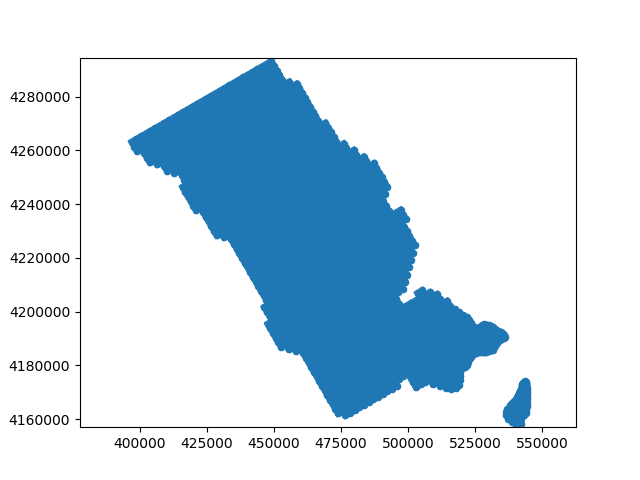

In [14]:
g14=model.subdomain_grid(14)

plt.figure()
g14.plot_edges()
g14.plot_cells(centers=True)

<IPython.core.display.Javascript object>


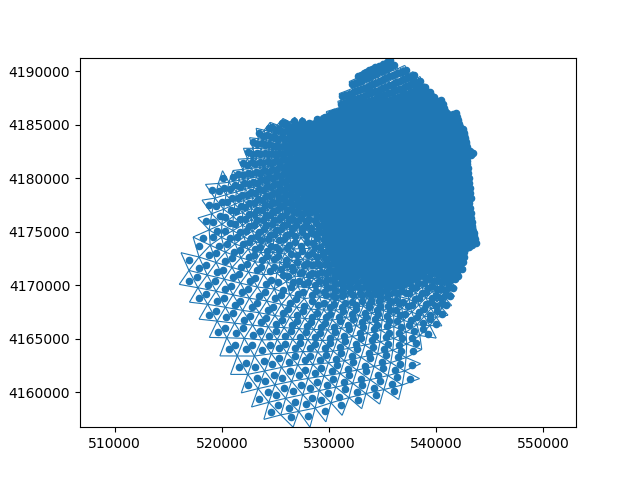

In [121]:
g15=model.subdomain_grid(15)

plt.figure()
g15.plot_edges()
g15.plot_cells(centers=True)

In [16]:
g14.cells.dtype.names

('edges', 'nodes', '_center', 'mark', '_area', 'deleted', 'dv', 'Nk')

<IPython.core.display.Javascript object>


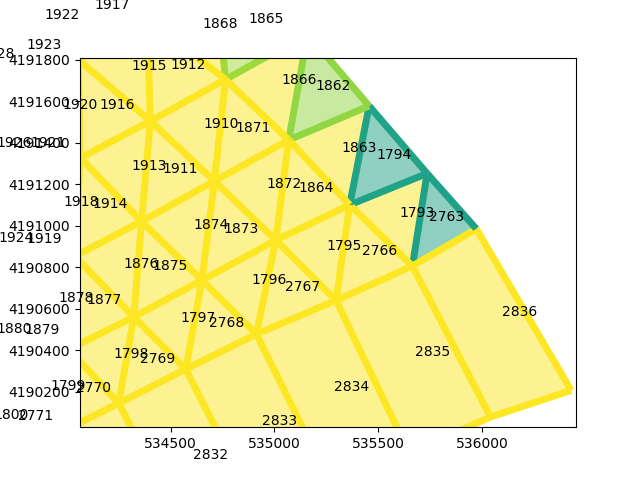

(534063.7120971476, 536453.2201714197, 4190029.525681338, 4191810.0946011986)

In [22]:
plt.figure()
ecoll=g14.plot_edges(values=g14.edges['edge_depth'],lw=5)# ,labeler='id')
ccoll=g14.plot_cells(values=g14.cells['dv'],alpha=0.5,labeler=lambda i,r:str(i))

plt.setp([ecoll,ccoll],clim=[0,10])
plt.axis((534063.7120971476, 536453.2201714197, 4190029.525681338, 4191810.0946011986))

<IPython.core.display.Javascript object>


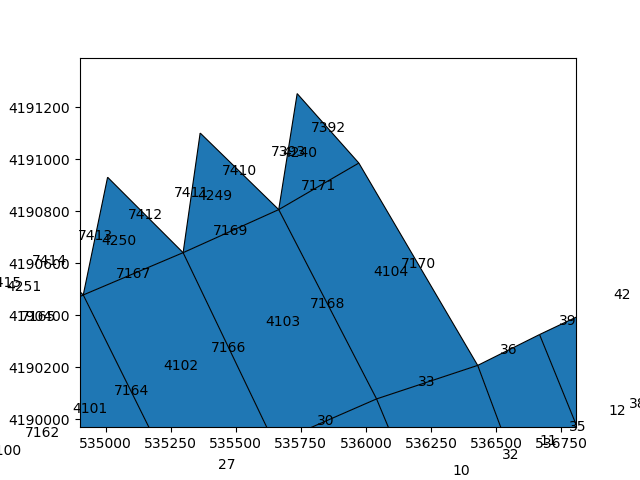

(534063.7120971476, 536453.2201714197, 4190029.525681338, 4191810.0946011986)

In [112]:
# Maybe proc 15 is doing something bad in that quad
plt.figure()
ecoll=g15.plot_edges(labeler='id',color='k')
ccoll=g15.plot_cells(labeler=lambda i,r:str(i))

plt.setp(plt.gca().texts,ha='center',va='center')
plt.axis((534063.7120971476, 536453.2201714197, 4190029.525681338, 4191810.0946011986))

In [41]:
# is it a w issue?
ds=xr.open_dataset(model.map_outputs()[14])

<IPython.core.display.Javascript object>


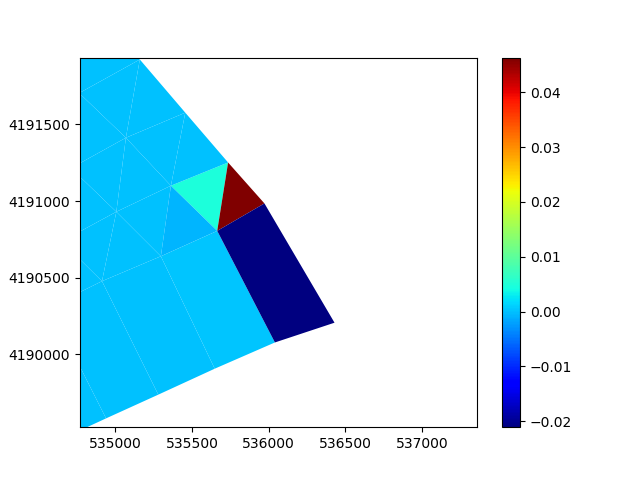

(534769.9341649204, 537358.0912175023, 4189525.4238538216, 4191936.1669148956)

In [49]:
plt.figure()
#g14.plot_cells(values=ds.dv.values,cmap='jet')
ccoll=g14.plot_cells(values=ds.w.isel(time=7,Nkw=0).values,cmap='jet')
plt.colorbar(ccoll)
plt.axis('equal')
plt.axis((534769.9341649204, 537358.0912175023, 4189525.4238538216, 4191936.1669148956))

In [46]:
plt.axis()

(534769.9341649204, 537358.0912175023, 4189525.4238538216, 4191936.1669148956)

In [50]:
# Can I doctor up the initial condition to smooth it out?
run_dir="/opt/sfb_ocean/suntans/runs/merge_002-20170610dbg/"


In [103]:
ic_ds=xr.open_dataset("/opt/sfb_ocean/suntans/runs/merge_002-20170610/Estuary_IC.nc")


In [62]:
ic_g=unstructured_grid.UnstructuredGrid.from_ugrid(ic_ds,mesh_name='suntans_mesh')

In [72]:
M=ic_g.smooth_matrix()

In [104]:
for scalar in ['salt','temp']:
    print(scalar)
    all_scal=ic_ds[scalar].values.copy() # time, layer, cell

    for k in range(ic_ds.dims['Nk']):
        print(k,end=', ')
        scal=all_scal[0,k,:].copy()

        for it in range(150):
            scal[...]=M.dot(scal)
        all_scal[0,k,:]=scal
    print()
    # replace all at once
    ic_ds[scalar]=ic_ds[scalar].dims,all_scal


salt
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 
temp
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 


<IPython.core.display.Javascript object>


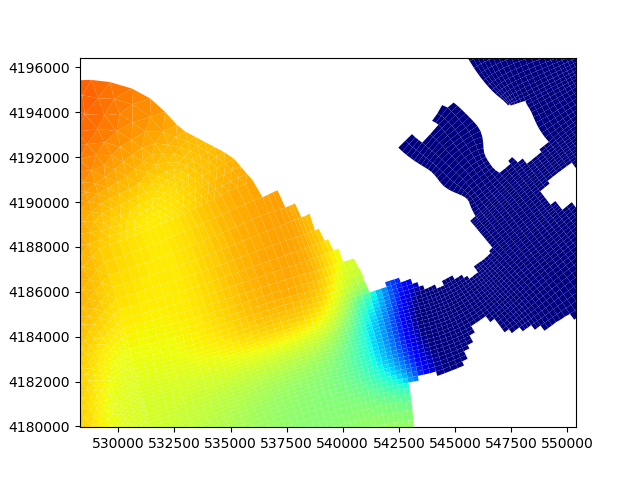

(528293.8115196724, 550392.875264927, 4179966.386486823, 4196433.753342158)

In [105]:
plt.figure()
ic_g.plot_cells(values=ic_ds.salt.isel(time=0,Nk=0).values,
                cmap='jet',clim=[30,34])
plt.axis('equal')
plt.axis((528293.8115196724, 550392.875264927, 4179966.386486823, 4196433.753342158))

In [109]:
fn="/opt/sfb_ocean/suntans/runs/merge_002-20170610dbg/Estuary_IC.nc"
os.path.exists(fn) and os.unlink(fn)
ic_ds.to_netcdf(fn)

<IPython.core.display.Javascript object>


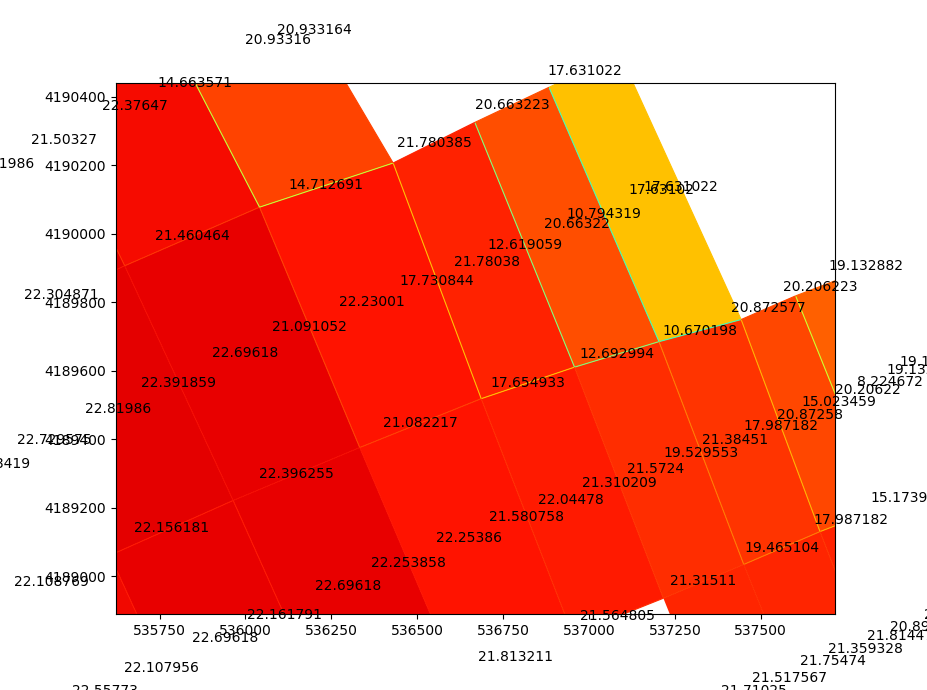

In [128]:
plt.figure()
zoom=(534680.1058982891, 538403.8254784422, 4188623.3048984814, 4191398.0765856276)

g15.plot_edges(values=g15.edges['edge_depth'],clip=zoom,
               cmap='jet',clim=[0,25],labeler=lambda i,r: str(r['edge_depth']))
g15.plot_cells(values=g15.cells['dv'],clip=zoom,
               cmap='jet',clim=[0,25],labeler=lambda i,r: str(r['dv']))

plt.setp(plt.gca().texts,ha='center',va='center')
None

In [127]:
plt.gca().axis()

(534680.1058982891, 538403.8254784422, 4188623.3048984814, 4191398.0765856276)

In [129]:
# What about global edge depths and cell depths?
edge_xyz=np.loadtxt('/opt/sfb_ocean/suntans/runs/merge_002-20170610/depths.dat-edge')
cell_xyz=np.loadtxt('/opt/sfb_ocean/suntans/runs/merge_002-20170610/depths.dat-voro')
gg=unstructured_grid.UnstructuredGrid.read_suntans('/opt/sfb_ocean/suntans/runs/merge_002-20170610/')


<IPython.core.display.Javascript object>


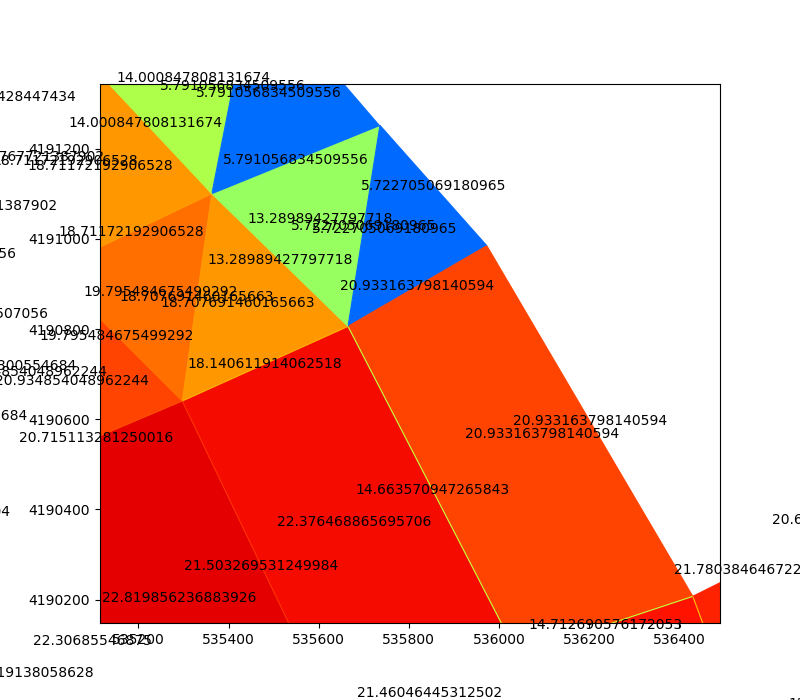

In [133]:
# edge_xyz.shape,cell_xyz.shape, gg.Nedges(), gg.Ncells()
plt.figure(figsize=(8,7))
zoom=(534680., 538403., 4188623., 4191398.)

gg.plot_edges(values=edge_xyz[:,2],clip=zoom,
              cmap='jet',clim=[0,25],labeler=lambda i,r: str(edge_xyz[i,2]))
gg.plot_cells(values=cell_xyz[:,2],clip=zoom,
              cmap='jet',clim=[0,25],labeler=lambda i,r: str(cell_xyz[i,2]))

plt.setp(plt.gca().texts,ha='center',va='center')
None